In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors, LocalOutlierFactor
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
import nfl_data_py as nfl
import datetime as dt
import warnings
warnings.filterwarnings('ignore')
today = dt.date.today()
year = today.year
pd.set_option("display.max_columns", None)
pd.set_option('display.max_colwidth', None)

In [13]:
df = nfl.import_schedules(years=range(year-3,year))

In [14]:
# Prepare dataframe by dropping irrelevant predictors and formatting columns for KNN
df['Under'] = np.where(df['total'] < df['total_line'], 1, 0)
df['Push'] = np.where(df['total'] == df['total_line'], 1, 0)
df = df[df.Push != 1]

def date_to_month(time_str):
    year, month, day = map(int, time_str.split('-'))
    return month
df['month'] = df['gameday'].apply(date_to_month)
# Function to convert time to seconds
def time_to_seconds(time_str):
    hours, minutes = map(int, time_str.split(':'))
    return hours * 3600 + minutes * 60
# Apply the function to the 'time' column
df['gametime'] = df['gametime'].apply(time_to_seconds)

dict_day = {"weekday": {"Sunday": 0, "Monday": 1, "Tuesday": 2, "Wednesday": 3, "Thursday": 4, "Friday": 5, "Saturday": 6}}
df.replace(dict_day, inplace=True)
dict_roof = {"roof": {"outdoors": 0, "dome": 1, "closed": 2, "open": 3}}
df.replace(dict_roof, inplace=True)
dict_surface = {"surface": {"grass": 0, "grass ": 0, "fieldturf": 1, "astroturf": 2, "sportturf": 3, "matrixturf": 4, "astroplay": 5, "a_turf": 6, "dessograss": 7}}
df.replace(dict_surface, inplace=True)
dict_surface = {"surface": {"grass": 0, "grass ": 0, "fieldturf": 1, "astroturf": 2, "sportturf": 3, "matrixturf": 4, "astroplay": 5, "a_turf": 6, "dessograss": 7}}
df.replace(dict_surface, inplace=True)

df = pd.get_dummies(df, drop_first=True, columns=['game_type', 'location', 'stadium_id'])
df.reset_index(drop=True, inplace=True)

In [15]:
feat_df = df.dropna()
X_variables = feat_df.drop(['Under', 'game_id', 'gameday', 'away_team', 'away_score', 'home_team', 'home_score', 'result', 'total', 'overtime', 'old_game_id', 'gsis', 'nfl_detail_id', 'pfr', 'pff', 'espn', 'ftn', 'temp', 'wind', 'away_qb_id', 'home_qb_id', 'away_qb_name', 'home_qb_name', 'away_coach', 'home_coach', 'referee', 'stadium'], axis=1).copy()
y_variable = feat_df['Under'].copy()

selected_X = SelectKBest(f_classif, k=12)
selected_X.fit(X_variables, y_variable)

indices = selected_X.get_support(indices=True)
selected_features = X_variables.columns[indices]

# Accuracy Testing

Total accuracy score=52.66%

Classification Report:
              precision    recall  f1-score   support

        Over       0.47      0.31      0.37        77
       Under       0.55      0.71      0.62        92

    accuracy                           0.53       169
   macro avg       0.51      0.51      0.50       169
weighted avg       0.51      0.53      0.51       169



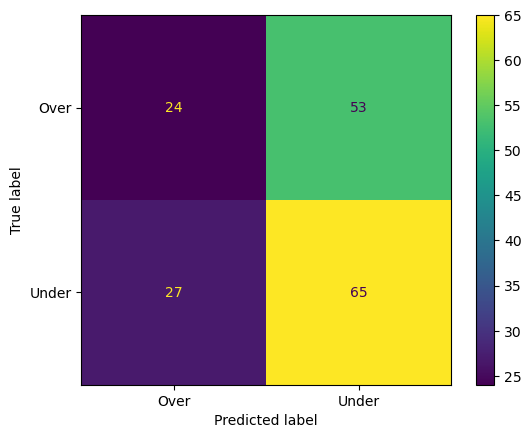

In [16]:
# Model building
y = df.Under
X = df[selected_features]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7, stratify=y)

# Define pipeline for use after split
pipe = [('scaler', StandardScaler()),
         ('knn', KNeighborsClassifier())]
pipeline = Pipeline(pipe)
parameters = {'knn__n_neighbors': np.arange(1,50)}

knncv = GridSearchCV(estimator=pipeline,
                     param_grid=parameters,
                     n_jobs=-1,
                     cv=5)

classif = knncv.fit(X_train,y_train)

# pipe2 = Pipeline([
#     ('scaler', StandardScaler()),
#     ('lof', LocalOutlierFactor(novelty=True))
# ])

# pipe2.fit(X_train)
# y_test_nov = pipe2.predict(X_test)

# mask = [y == 1 for y in y_test_nov]

# X_test = X_test[mask]
# y_test = y_test[mask]
y_pred = classif.predict(X_test)
y_true = y_test

print(f'Total accuracy score={accuracy_score(y_true, y_pred):.2%}')
print(f'\nClassification Report:')
print(classification_report(y_true, y_pred, target_names=['Over', 'Under']))

cm = confusion_matrix(y_true, y_pred)
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Over', 'Under'])
display.plot()
plt.grid(False)
plt.show()

# Weekly Plays

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors, LocalOutlierFactor
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
import nfl_data_py as nfl
import datetime as dt
import warnings
import requests
warnings.filterwarnings('ignore')
today = dt.date.today()
year = today.year

# Variable declaration
df = nfl.import_schedules(years=range(year-3,year+1))
currSeason = df[df.season == year]
predWeek = currSeason[['week', 'total']].dropna()
if np.isnan(predWeek.week.max()):
    predWeek = 1
else:
    predWeek = predWeek.week.max()

# Fix wind temp NaNs


# Prepare dataframe by dropping irrelevant predictors and formatting columns for KNN
df['Under'] = np.where(df['total'] < df['total_line'], 1, 0)
df['Push'] = np.where(df['total'] == df['total_line'], 1, 0)
df = df[df.Push != 1]

def date_to_month(time_str):
    year, month, day = map(int, time_str.split('-'))
    return month
df['month'] = df['gameday'].apply(date_to_month)
# Function to convert time to seconds
def time_to_seconds(time_str):
    hours, minutes = map(int, time_str.split(':'))
    return hours * 3600 + minutes * 60
# Apply the function to the 'time' column
df['gametime'] = df['gametime'].apply(time_to_seconds)

dict_day = {"weekday": {"Sunday": 0, "Monday": 1, "Tuesday": 2, "Wednesday": 3, "Thursday": 4, "Friday": 5, "Saturday": 6}}
df.replace(dict_day, inplace=True)
dict_roof = {"roof": {"outdoors": 0, "dome": 1, "closed": 2, "open": 3}}
df.replace(dict_roof, inplace=True)
dict_surface = {"surface": {"grass": 0, "grass ": 0, "fieldturf": 1, "astroturf": 2, "sportturf": 3, "matrixturf": 4, "astroplay": 5, "a_turf": 6, "dessograss": 7}}
df.replace(dict_surface, inplace=True)
dict_surface = {"surface": {"grass": 0, "grass ": 0, "fieldturf": 1, "astroturf": 2, "sportturf": 3, "matrixturf": 4, "astroplay": 5, "a_turf": 6, "dessograss": 7}}
df.replace(dict_surface, inplace=True)

df = pd.get_dummies(df, drop_first=True, columns=['game_type', 'location', 'stadium_id'])
df.reset_index(drop=True, inplace=True)

# Feature selection
feat_df = df.dropna()
X_variables = feat_df.drop(['Under', 'game_id', 'gameday', 'away_team', 'away_score', 'home_team', 'home_score', 'result', 'total', 'overtime', 'old_game_id', 'gsis', 'nfl_detail_id', 'pfr', 'pff', 'espn', 'ftn', 'temp', 'wind', 'away_qb_id', 'home_qb_id', 'away_qb_name', 'home_qb_name', 'away_coach', 'home_coach', 'referee', 'stadium'], axis=1).copy()
y_variable = feat_df['Under'].copy()

selected_X = SelectKBest(f_classif, k=16)
selected_X.fit(X_variables, y_variable)

indices = selected_X.get_support(indices=True)
selected_features = X_variables.columns[indices]

# # Model building
train_df = df[(df.season < year) & (df.week < predWeek) | (df.season < year)]
test_df = df[(df.season == year) & (df.week == predWeek+1)]
X_train = train_df[selected_features]
y_train = train_df.Under
X_test = test_df[selected_features]
y_test = test_df.Under

# Define pipeline for use after split
pipe = [('scaler', StandardScaler()),
         ('knn', KNeighborsClassifier())]
pipeline = Pipeline(pipe)
parameters = {'knn__n_neighbors': np.arange(1,50)}

knncv = GridSearchCV(estimator=pipeline,
                     param_grid=parameters,
                     n_jobs=-1,
                     cv=5)

classif = knncv.fit(X_train,y_train)

# pipe2 = Pipeline([
#     ('scaler', StandardScaler()),
#     ('lof', LocalOutlierFactor(novelty=True))
# ])

# pipe2.fit(X_train)
# y_test_nov = pipe2.predict(X_test)

# mask = [y == 1 for y in y_test_nov]

# X_test = X_test[mask]
# y_test = y_test[mask]
y_pred = classif.predict(X_test)
y_true = y_test
X_test['Prediction'] = y_pred

# Predicted Plays log
nextPlays = pd.merge(right=X_test, left=test_df, right_index=True, left_index=True, how='left')
nextPlays = nextPlays[nextPlays.Prediction == 1]
nextPlays = nextPlays[['game_id', 'season', 'week_x', 'home_team', 'away_team', 'gametime', 'weekday', 'total_line', 'under_odds_x']]
nextPlays.columns = ['Game ID', 'Season', 'Week', 'Home', 'Away', 'Start Time', 'Day', 'Total Line', 'Under Odds']

# Value cleanup
dict_day = {"Day": {0: "Sunday", 1: "Monday", 2: "Tuesday", 3: "Wednesday", 4: "Thursday", 5: "Friday", 6: "Saturday"}}
nextPlays.replace(dict_day, inplace=True)
def seconds_to_hhmm(total_seconds):
    hours = total_seconds // 3600
    minutes = (total_seconds % 3600) // 60
    if hours > 12:
        hours = hours - 12
    return f"{hours}:{minutes:02}"
nextPlays['Start Time'] = nextPlays['Start Time'].apply(seconds_to_hhmm)

In [18]:
nextPlays

,Game ID,Season,Week,Home,Away,Start Time,Day,Total Line,Under Odds
860,2024_02_BUF_MIA,2024,2,MIA,BUF,8:15,Thursday,51.0,-110.0
862,2024_02_LAC_CAR,2024,2,CAR,LAC,1:00,Sunday,41.5,-110.0
863,2024_02_NO_DAL,2024,2,DAL,NO,1:00,Sunday,44.5,-110.0
864,2024_02_TB_DET,2024,2,DET,TB,1:00,Sunday,48.5,-112.0
865,2024_02_IND_GB,2024,2,GB,IND,1:00,Sunday,47.0,-112.0
866,2024_02_CLE_JAX,2024,2,JAX,CLE,1:00,Sunday,44.5,-112.0
867,2024_02_SF_MIN,2024,2,MIN,SF,1:00,Sunday,46.5,-112.0
868,2024_02_SEA_NE,2024,2,NE,SEA,1:00,Sunday,41.0,-110.0
869,2024_02_NYJ_TEN,2024,2,TEN,NYJ,1:00,Sunday,43.5,-110.0
870,2024_02_NYG_WAS,2024,2,WAS,NYG,1:00,Sunday,42.0,-112.0


In [19]:
import nfl_data_py as nfl
import requests

# Variable declaration
df = nfl.import_schedules(years=[2024])
# Function to get weather data from OpenWeatherMap API
def get_weather_data(lat, lon, date, api_key):
    url = f"https://api.openweathermap.org/data/2.5/onecall/forecast?lat={lat}&lon={lon}&dt={date}&appid={api_key}"
    response = requests.get(url)
    data = response.json()
    if 'current' in data:
        return data['current']['temp'], data['current']['wind_speed']
    return None, None

# Your OpenWeatherMap API key
API_KEY = 'e329b979ffb2b8c3ed114eadb8ca777c'

# Example coordinates for stadiums (you would need to map these properly)
stadium_coords = {
    "SoFi Stadium": (33.953, -118.339),
    "MetLife Stadium": (40.813778, -74.074310),
    "GEHA Field at Arrowhead Stadium": (39.048786, -94.484566),
    "New Era Field": (42.774, -78.787),
    "Levi's Stadium": (37.403, -121.970),
    "Raymond James Stadium": (27.975832, -82.503403),
    "Ford Field": (42.340115, -83.046341),
    "AT&T Stadium": (32.747768, -97.092773),
    "Lincoln Financial Field": (39.900898, -75.168098),
    "M&T Bank Stadium": (39.278088, -76.623322),
    "Allegiant Stadium": (36.0908, -115.183),
    "NRG Stadium": (29.684723, -95.410835),
    "U.S. Bank Stadium": (44.974, -93.258),
    "Nissan Stadium": (36.166389, -86.771385),
    "Lumen Field": (47.595097, -122.332245),
    "Empower Field at Mile High": (39.7439, -105.019997),
    "Lambeau Field": (44.501381, -88.062218),
    "State Farm Stadium": (33.527283, -112.263275),
    "Hard Rock Stadium": (25.957960, -80.239311),
    "FirstEnergy Stadium": (41.506035, -81.700058),
    "Soldier Field": (41.8623, -87.6167),
    "TIAA Bank Stadium": (30.3238, -81.6372),
    "Gillette Stadium": (42.0909, -71.2643),
    "FedExField": (38.9078, -76.8645),
    "Lucas Oil Stadium": (39.7601, -86.1639),
    "Bank of America Stadium": (35.2251, -80.8528),
    "Mercedes-Benz Stadium": (33.7554, -84.4008),
    "Mercedes-Benz Superdome": (29.9511, -90.0812),
    "Paycor Stadium": (39.0955, -84.5161),
    "Acrisure Stadium": (40.4468, -80.0158),
    "Paul Brown Stadium": (39.0955, -84.5161),
    "Heinz Field": (40.4468, -80.0158),
    "Tottenham Stadium": (51.6043, -0.0665),
    "Wembley Stadium": (51.5558, -0.2796),
    "Allianz Arena": (48.2188, 11.6247),
    "Azteca Stadium": (19.3029, -99.1505)
}

# Fill in missing wind and temperature data
for index, row in df.iterrows():
    if pd.isnull(row['temp']) or pd.isnull(row['wind']):
        stadium = row['stadium']
        if stadium in stadium_coords:
            lat, lon = stadium_coords[stadium]
            game_date = pd.to_datetime(row['gameday'])
            temp, wind = get_weather_data(lat, lon, game_date, API_KEY)
            df.at[index, 'temp'] = temp
            df.at[index, 'wind'] = wind

In [23]:
temp, wind = get_weather_data(19.3029, -99.1505, pd.to_datetime('2024-09-07'), API_KEY)